# Time Series with Store Sales TS Forecasting

DATA SOURCE : https://www.kaggle.com/c/store-sales-time-series-forecasting/data

In [26]:
import pandas as pd
import warnings
import itertools

In [27]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [28]:
warnings.filterwarnings("ignore")

## train data

In [29]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

df = pd.read_csv('data/train.csv',dtype=dtype, parse_dates=['date'],
    infer_datetime_format=True)

In [30]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [31]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [32]:
prod_cat = df.family.unique()
len(prod_cat)

33

In [33]:
shop = df.store_nbr.unique()

In [34]:
#df_train = df.set_index(['store_nbr','family'], append=True)
df_train = df.set_index(['store_nbr','family'])
df_train.head()

id       date  sales  onpromotion
store_nbr family                                       
1         AUTOMOTIVE   0 2013-01-01    0.0            0
          BABY CARE    1 2013-01-01    0.0            0
          BEAUTY       2 2013-01-01    0.0            0
          BEVERAGES    3 2013-01-01    0.0            0
          BOOKS        4 2013-01-01    0.0            0

In [35]:
df_train.index.names

FrozenList(['store_nbr', 'family'])

In [36]:
df_train.loc[('1','AUTOMOTIVE')].head()

id       date  sales  onpromotion
store_nbr family                                         
1         AUTOMOTIVE     0 2013-01-01    0.0            0
          AUTOMOTIVE  1782 2013-01-02    2.0            0
          AUTOMOTIVE  3564 2013-01-03    3.0            0
          AUTOMOTIVE  5346 2013-01-04    3.0            0
          AUTOMOTIVE  7128 2013-01-05    5.0            0

In [37]:
colNames = df.columns
for i, feature in enumerate(colNames):
    print(colNames[i]+" "+ str(len(df[feature].value_counts())))

id 3000888
date 1684
store_nbr 54
family 33
sales 379610
onpromotion 362


In [38]:
print("Number of Time Series (train):")
unique_keys_train = set(zip(df.store_nbr, df.family))
print(len(unique_keys_train))

Number of Time Series (train):
1782


### Missing dates

In [39]:
missing_ds_df = df.groupby(['store_nbr', 'family']).resample('D', on='date')['sales'] \
        .first().loc[lambda x: x.isna()].index.to_frame(index=False)

missing_ds_df

,store_nbr,family,date
0,1,AUTOMOTIVE,2013-12-25
1,1,AUTOMOTIVE,2014-12-25
2,1,AUTOMOTIVE,2015-12-25
3,1,AUTOMOTIVE,2016-12-25
4,1,BABY CARE,2013-12-25
...,...,...,...
7123,9,SCHOOL AND OFFICE SUPPLIES,2016-12-25
7124,9,SEAFOOD,2013-12-25
7125,9,SEAFOOD,2014-12-25
7126,9,SEAFOOD,2015-12-25


In [40]:
missing_ds_df.date.unique()

array(['2013-12-25T00:00:00.000000000', '2014-12-25T00:00:00.000000000',
       '2015-12-25T00:00:00.000000000', '2016-12-25T00:00:00.000000000'],
      dtype='datetime64[ns]')

Christmas days are abscent

## Total sales per day for each store

In [41]:
store_array=[]
for store in shop:
    d=df_train.loc[store]
    data_grouped = d.groupby('date')
    t=data_grouped.sum().reset_index()
    t['store_nbr']=store
    store_array.append(t)

In [42]:
total_daily_sales = pd.concat(store_array, ignore_index=True)

In [43]:
total_daily_sales.head()

,date,id,sales,onpromotion,store_nbr
0,2013-01-01,528,0.000000,0,1
1,2013-01-02,59334,7417.147949,0,1
2,2013-01-03,118140,5873.244141,0,1
3,2013-01-04,176946,5919.878906,0,1
4,2013-01-05,235752,6318.785156,0,1


In [44]:
total_daily_sales=total_daily_sales[['store_nbr','date','sales','onpromotion']]

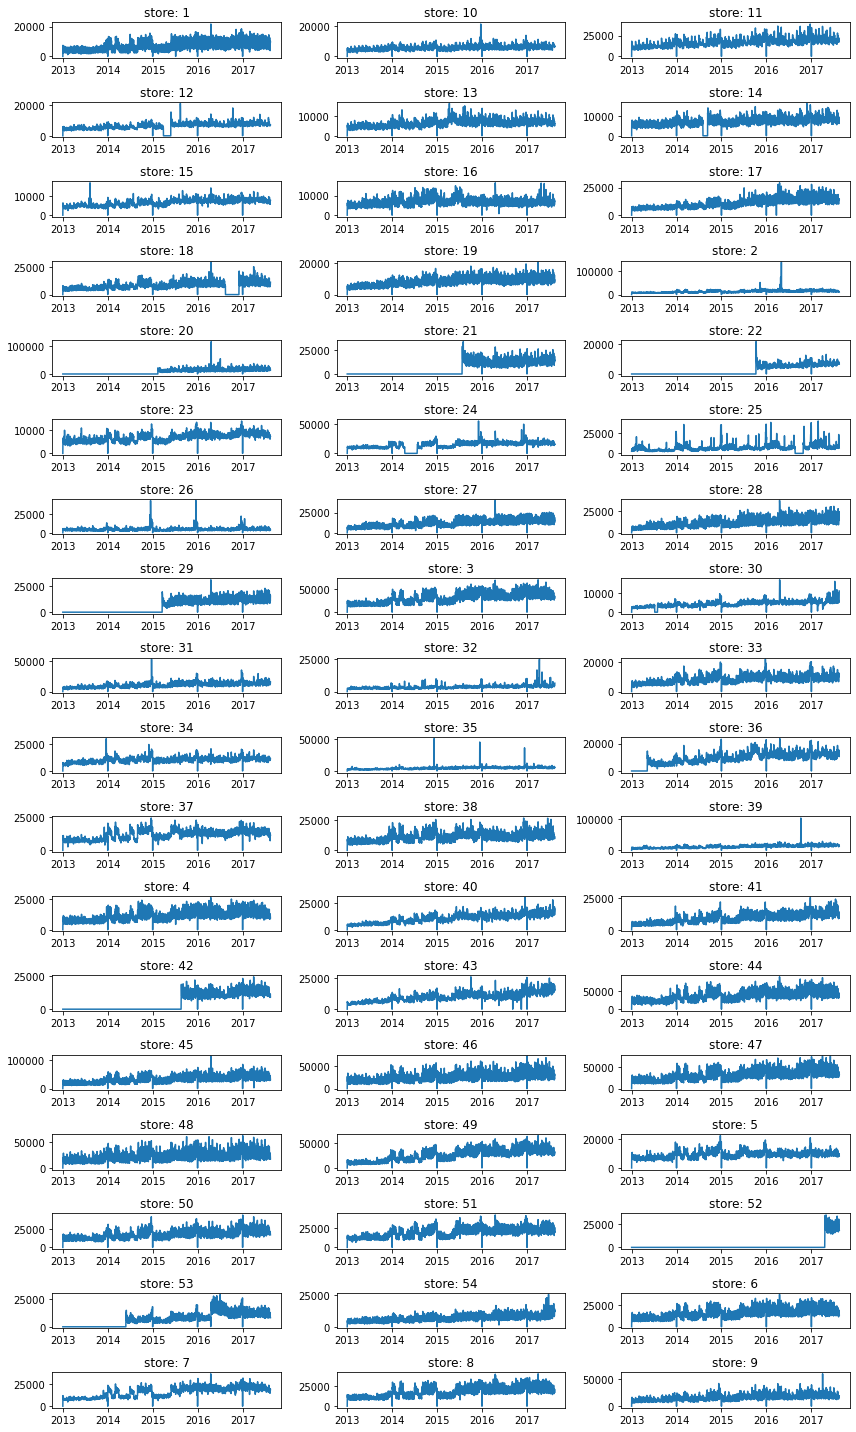

In [45]:
fig, axs = plt.subplots(nrows=18,ncols=3, figsize=(12,20))
i = j = 0
for store in shop:
    data=total_daily_sales[total_daily_sales['store_nbr']== store]
    axs[i,j].plot(data.date, data.sales)
    axs[i,j].set_title(f'store: {store}')     
    if j == 2:
        i+=1
        j= 0
    else:
        j+=1
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

## Store_1 modelling

In [46]:
store_1=total_daily_sales[total_daily_sales['store_nbr']== '1']
store_1.set_index('date',inplace=True)

In [47]:
store_1.head()

,store_nbr,sales,onpromotion
date,,,
2013-01-01,1,0.000000,0
2013-01-02,1,7417.147949,0
2013-01-03,1,5873.244141,0
2013-01-04,1,5919.878906,0
2013-01-05,1,6318.785156,0


In [48]:
import statsmodels.api as sm
# this function does not handle missing dates.

In [49]:
z = store_1['sales'].resample('M').mean()

In [50]:
decomposition_z = sm.tsa.seasonal_decompose(z, model='additive')

<Figure size 1200x1200 with 0 Axes>

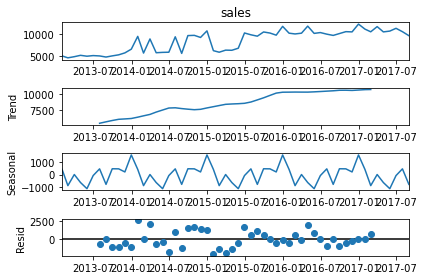

In [51]:
from matplotlib.pyplot import figure

figure(figsize=(15,15), dpi=80)

#plt.figure()
decomposition_z.plot()
plt.show()

In [52]:
# in AR I MA -> p,d,q 
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [53]:
seasons = 12 # my data granularity is monthly -> so to take 1 year as a SEASON, i have to take
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] # if x was (0,1,0), -> (0,1,0,12)
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[0]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[1]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[2]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[3]))

SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 1, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 1, 12)


In [54]:
min_pdq = (99999,99999,99999)
min_spdq = (99999,99999,99999,12)
min_AIC = 99999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(z, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model.fit()
      print('Model={}X{}. AIC= {}'.format(param, sparam, predictions.aic))
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)

Model=(0, 0, 0)X(0, 0, 0, 12). AIC= 1156.9902224580808
Model=(0, 0, 0)X(0, 0, 1, 12). AIC= 866.647568306137
Model=(0, 0, 0)X(0, 1, 0, 12). AIC= 793.8522726647637
Model=(0, 0, 0)X(0, 1, 1, 12). AIC= 566.0103081052335
Model=(0, 0, 0)X(1, 0, 0, 12). AIC= 806.9241457994532
Model=(0, 0, 0)X(1, 0, 1, 12). AIC= 795.0323967666837
Model=(0, 0, 0)X(1, 1, 0, 12). AIC= 585.3511085059376
Model=(0, 0, 0)X(1, 1, 1, 12). AIC= 560.1897251673166
Model=(0, 0, 1)X(0, 0, 0, 12). AIC= 1083.8297623767112
Model=(0, 0, 1)X(0, 0, 1, 12). AIC= 824.4844270349066
Model=(0, 0, 1)X(0, 1, 0, 12). AIC= 771.1100201201065
Model=(0, 0, 1)X(0, 1, 1, 12). AIC= 543.7358678769609
Model=(0, 0, 1)X(1, 0, 0, 12). AIC= 804.3647437284384
Model=(0, 0, 1)X(1, 0, 1, 12). AIC= 770.3353784710683
Model=(0, 0, 1)X(1, 1, 0, 12). AIC= 581.9775378728024
Model=(0, 0, 1)X(1, 1, 1, 12). AIC= 544.4796168816566
Model=(0, 1, 0)X(0, 0, 0, 12). AIC= 952.5853659424253
Model=(0, 1, 0)X(0, 0, 1, 12). AIC= 745.7685031705969
Model=(0, 1, 0)X(0, 1, 0, 1

In [55]:
model = sm.tsa.statespace.SARIMAX(z, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
# (0, 1, 0)X(1, 0, 1, 12)
model2 = sm.tsa.statespace.SARIMAX(z, order=(0, 1, 0), seasonal_order= (1, 0, 1, 12), enforce_stationarity=False)
results = model.fit()
results2 = model2.fit()
# we've taken 2 models so that we can compare their predictions 
results.summary() #.tables[1]  # AIC => needs to be lowest 
# results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -240.369
Date:                            Mon, 14 Feb 2022   AIC                            488.737
Time:                                    21:26:12   BIC                            494.206
Sample:                                01-31-2013   HQIC                           490.450
                                     - 08-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9586      0.082    -11.757      0.000      -1.118      -0.799
ma.L1          0.7443      0.166      4.486      0.000       0.419       1.069
ma.S.L12      -0.9967      0.221     -4.508      0.000      -1.430      -0.563
sigma2      7.225e+05   3.05e-07   2.37e+12      0.000    7.22e+05    7.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.89   Prob(JB):                         0.29
Heteroskedasticity (H):               0.42   Skew:                             0.45
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.92e+28. Standard errors may be unstable.
"""

In [56]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                   56
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -371.400
Date:                              Mon, 14 Feb 2022   AIC                            748.800
Time:                                      21:26:13   BIC                            754.013
Sample:                                  01-31-2013   HQIC                           750.710
                                       - 08-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7034      0.397     -1.772      0.076      -1.482       0.075
ma.S.L12       1.0000      0.555      1.801      0.072      -0.088       2.088
sigma2      1.955e+06   7.19e+05      2.720      0.007    5.46e+05    3.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.28   Jarque-Bera (JB):                 4.44
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.14   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 

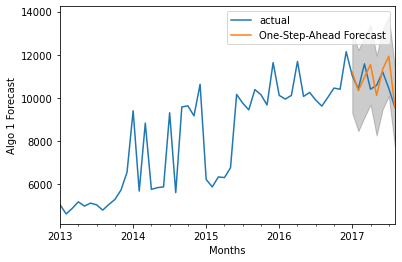

In [57]:
# model 1 predictions

pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = z['2013':].plot(label='actual') # ACTUAL DATA PLOT
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 

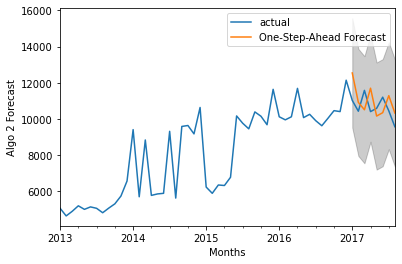

In [58]:
# model 2 predictions

pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred2_ci = pred2.conf_int()


plt.figure()
bx = z['2013':].plot(label='actual') # ACTUAL DATA PLOT
pred2.predicted_mean.plot(ax=bx, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
bx.fill_between(pred2_ci.index, pred2_ci.iloc[:,0], pred2_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
bx.set_xlabel('Months')
bx.set_ylabel('Algo 2 Forecast')
plt.legend()
plt.show() 

In [61]:
# Root Mean Squared  Error
(results.mse)**0.5

1763.14743452905

In [62]:
(results2.mse)**0.5

1820.776828633959

In [72]:
# Root Mean Squared Logarithmic Error
def rmsle(actual, prediction):
    a=actual
    p=prediction
    s=0
    for i in range(len(p)):
        s+=np.log(p[i]/a[i])
    return (s/len(p))**0.5
        

In [74]:
rmsle(z.loc['20170131':],pred.predicted_mean) # the first model produces a smaller error

0.1397681386736637

In [73]:
rmsle(z.loc['20170131':],pred2.predicted_mean)

0.16869024371222124